In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torch.utils.data import Dataset
import torch
from mpl_toolkits.axes_grid1 import ImageGrid
import torch.nn as nn
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchvision.transforms.transforms import RandomPerspective, RandomRotation
from torchsummary import summary
from functools import partial
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_csv('icml_face_data.csv')
df.head(10)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


In [4]:
df = df.rename({' Usage':'usage', ' pixels':'pixels'}, axis =1)
df = df.drop(['usage'],axis=1)
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [5]:
sad_neutral = df[(df['emotion'] == 4) | (df['emotion'] == 6)].copy()
sad_neutral['emotion'] = np.where(sad_neutral['emotion'] == 4, 0, 1)
sad_neutral['emotion'].value_counts()

1    6198
0    6077
Name: emotion, dtype: int64

In [6]:
def split(df):
  return  df.drop(['emotion'], axis=1), df['emotion']

In [7]:
X_train, X_test_final = train_test_split(df, test_size=0.1, random_state=1,stratify=df['emotion'])
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=1, stratify=X_train['emotion'])
X_test = X_test_final.copy()
X_test_final, y_test_final = split(X_test_final)

In [8]:
X_train['emotion'] = np.where(X_train['emotion'] == 6, 4, X_train['emotion'])
X_val['emotion'] = np.where(X_val['emotion'] == 6, 4, X_val['emotion'])
X_test['emotion'] = np.where(X_test['emotion'] == 6, 4, X_test['emotion'])


X_train['emotion'].value_counts()

4    8837
3    6472
2    3687
0    3566
5    2882
1     394
Name: emotion, dtype: int64

In [9]:
X_train, y_train = split(X_train)
X_val, y_val = split(X_val)
X_test, y_test = split(X_test)
X_train = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_train).flatten()))
X_test = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_test).flatten()))
X_test_final = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_test_final).flatten()))
X_val = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_val).flatten()))

In [10]:
print(sorted(Counter(y_train).items()))
ros = RandomOverSampler(random_state=0,sampling_strategy={0: 7500, 1: 700, 2: 7500, 3: 8500, 4: 8837, 5:7000})
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 3566), (1, 394), (2, 3687), (3, 6472), (4, 8837), (5, 2882)]
[(0, 7500), (1, 700), (2, 7500), (3, 8500), (4, 8837), (5, 7000)]


In [11]:
class FeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X_train = X.values
        self.y_train = y.values

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
      return torch.tensor(np.array(self.X_train[idx]).reshape((48,48)),dtype=torch.float)[None, :, :], self.y_train[idx]

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomPerspective(distortion_scale=0.1),
        transforms.RandomRotation((-10,10)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
    'test': transforms.Compose([
        transforms.ToTensor()
    ])
}
batch_size = 5
image_datasets = {'train': FeatureDataset(X_train,y_train), 
                  'val': FeatureDataset(X_val,y_val),
                  'test': FeatureDataset(X_test, y_test),
                  'test_final': FeatureDataset(X_test_final, y_test_final)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test','test_final']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'val','test','test_final']}
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad_Neutral', 'Surprise']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

Tesla T4


In [13]:
def imshow(inp, title=None):
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 2), axes_pad=0.5)
    if title is not None:
        for ax, im, tit in zip(grid, inp,title):
            ax.imshow(np.array(im).squeeze(),cmap='gray')
            ax.set_title(tit)            
    else:
        for ax, im in zip(grid, inp):
            ax.imshow(im,cmap='gray')

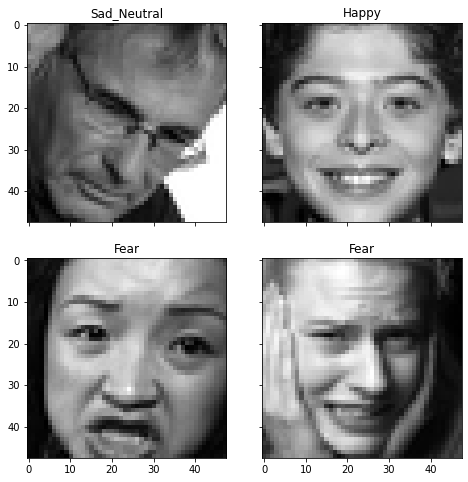

In [14]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(inputs,[class_names[x] for x in classes])

In [15]:
class block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        s = 0.5 if subsample else 1.0
        
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3,stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.dropout = nn.Dropout2d(0.2)
        self.relu2 = nn.ReLU()

        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    def shortcut(self, z, x):
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x        
    
    def forward(self, x, shortcuts=False):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        z = self.dropout(z)
        
        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        
        return z
    


class ResNet(nn.Module):
    def __init__(self, n, n_classes,shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts
        
        self.convIn = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn   = nn.BatchNorm2d(16, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        self.stack1 = nn.ModuleList([block(16, subsample=False) for _ in range(n)])

        self.stack2a = block(32, subsample=True)
        self.stack2b = nn.ModuleList([block(32, subsample=False) for _ in range(n-1)])

        self.stack3a = block(64, subsample=True)
        self.stack3b = nn.ModuleList([block(64, subsample=False) for _ in range(n-1)])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fcOut   = nn.Linear(64, n_classes, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):     
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)
        
        for l in self.stack1: z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack2a(z, shortcuts=self.shortcuts)
        for l in self.stack2b: 
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack3a(z, shortcuts=self.shortcuts)
        for l in self.stack3b: 
            z = l(z, shortcuts=self.shortcuts)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)

In [16]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes,num_epochs=25):

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for features, labels in dataloaders[phase]:
                features = features.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                labels = torch.squeeze(labels)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(features)

                    _, preds = torch.max(outputs, dim = 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * features.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [17]:
model_1 = ResNet(2,6)
summary(model_1.cuda(),(1,48,48))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             144
       BatchNorm2d-2           [-1, 16, 48, 48]              32
              ReLU-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 16, 48, 48]           2,304
       BatchNorm2d-5           [-1, 16, 48, 48]              32
              ReLU-6           [-1, 16, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]           2,304
       BatchNorm2d-8           [-1, 16, 48, 48]              32
         Dropout2d-9           [-1, 16, 48, 48]               0
             ReLU-10           [-1, 16, 48, 48]               0
            block-11           [-1, 16, 48, 48]               0
           Conv2d-12           [-1, 16, 48, 48]           2,304
      BatchNorm2d-13           [-1, 16, 48, 48]              32
             ReLU-14           [-1, 16,

In [20]:
model_2 = ResNet(3,6)
summary(model_2.cuda(),(1,48,48))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             144
       BatchNorm2d-2           [-1, 16, 48, 48]              32
              ReLU-3           [-1, 16, 48, 48]               0
            Conv2d-4           [-1, 16, 48, 48]           2,304
       BatchNorm2d-5           [-1, 16, 48, 48]              32
              ReLU-6           [-1, 16, 48, 48]               0
            Conv2d-7           [-1, 16, 48, 48]           2,304
       BatchNorm2d-8           [-1, 16, 48, 48]              32
         Dropout2d-9           [-1, 16, 48, 48]               0
             ReLU-10           [-1, 16, 48, 48]               0
            block-11           [-1, 16, 48, 48]               0
           Conv2d-12           [-1, 16, 48, 48]           2,304
      BatchNorm2d-13           [-1, 16, 48, 48]              32
             ReLU-14           [-1, 16,

In [23]:
model_3 = torchvision.models.resnet18(pretrained=False)
model_3.conv1 = nn.Conv2d(1,64, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False)
model_3.fc = nn.Linear(in_features=512, out_features=6)
summary(model_3.cuda(),(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]             576
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_1.parameters(),lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6)
model_1 = model_1.to(device)
model_1 = train_model(model_1, criterion, optimizer_conv,exp_lr_scheduler,dataloaders, dataset_sizes, num_epochs=22)

Epoch 1/22
----------
train Loss: 1.6565 Acc: 0.2498
val Loss: 1.4888 Acc: 0.3879

Epoch 2/22
----------
train Loss: 1.4379 Acc: 0.3960
val Loss: 1.2287 Acc: 0.5121

Epoch 3/22
----------
train Loss: 1.2335 Acc: 0.5052
val Loss: 1.0876 Acc: 0.5878

Epoch 4/22
----------
train Loss: 1.1375 Acc: 0.5484
val Loss: 1.0810 Acc: 0.5927

Epoch 5/22
----------
train Loss: 1.0748 Acc: 0.5744
val Loss: 1.0252 Acc: 0.6161

Epoch 6/22
----------
train Loss: 1.0189 Acc: 0.5977
val Loss: 1.0726 Acc: 0.5870

Epoch 7/22
----------
train Loss: 0.8974 Acc: 0.6484
val Loss: 0.9643 Acc: 0.6421

Epoch 8/22
----------
train Loss: 0.8660 Acc: 0.6602
val Loss: 0.9691 Acc: 0.6464

Epoch 9/22
----------
train Loss: 0.8478 Acc: 0.6696
val Loss: 0.9590 Acc: 0.6469

Epoch 10/22
----------
train Loss: 0.8362 Acc: 0.6742
val Loss: 0.9620 Acc: 0.6424

Epoch 11/22
----------
train Loss: 0.8220 Acc: 0.6782
val Loss: 0.9634 Acc: 0.6469

Epoch 12/22
----------
train Loss: 0.8073 Acc: 0.6860
val Loss: 0.9464 Acc: 0.6515

E

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_2.parameters(),lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6)
model_2 = model_2.to(device)
model_2 = train_model(model_2, criterion, optimizer_conv,exp_lr_scheduler,dataloaders, dataset_sizes, num_epochs=19)   

Epoch 1/19
----------
train Loss: 1.6605 Acc: 0.2509
val Loss: 1.5505 Acc: 0.3489

Epoch 2/19
----------
train Loss: 1.5289 Acc: 0.3375
val Loss: 1.3754 Acc: 0.4356

Epoch 3/19
----------
train Loss: 1.3130 Acc: 0.4626
val Loss: 1.1006 Acc: 0.5836

Epoch 4/19
----------
train Loss: 1.1790 Acc: 0.5313
val Loss: 1.0603 Acc: 0.6113

Epoch 5/19
----------
train Loss: 1.1016 Acc: 0.5604
val Loss: 1.0109 Acc: 0.6198

Epoch 6/19
----------
train Loss: 1.0546 Acc: 0.5845
val Loss: 0.9960 Acc: 0.6217

Epoch 7/19
----------
train Loss: 0.9370 Acc: 0.6322
val Loss: 0.9400 Acc: 0.6542

Epoch 8/19
----------
train Loss: 0.9022 Acc: 0.6448
val Loss: 0.9506 Acc: 0.6529

Epoch 9/19
----------
train Loss: 0.8834 Acc: 0.6518
val Loss: 0.9581 Acc: 0.6511

Epoch 10/19
----------
train Loss: 0.8707 Acc: 0.6592
val Loss: 0.9480 Acc: 0.6529

Epoch 11/19
----------
train Loss: 0.8540 Acc: 0.6646
val Loss: 0.9283 Acc: 0.6594

Epoch 12/19
----------
train Loss: 0.8439 Acc: 0.6715
val Loss: 0.9507 Acc: 0.6488

E

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_3.parameters(),lr=0.005)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6)
model_3 = model_3.to(device)
model_3 = train_model(model_3, criterion, optimizer_conv,exp_lr_scheduler,dataloaders, dataset_sizes, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.5046 Acc: 0.3641
val Loss: 1.5142 Acc: 0.3975

Epoch 2/15
----------
train Loss: 1.1946 Acc: 0.5180
val Loss: 1.1530 Acc: 0.5449

Epoch 3/15
----------
train Loss: 0.9934 Acc: 0.6063
val Loss: 1.0819 Acc: 0.6009

Epoch 4/15
----------
train Loss: 0.8010 Acc: 0.6929
val Loss: 1.0752 Acc: 0.6085

Epoch 5/15
----------
train Loss: 0.6155 Acc: 0.7701
val Loss: 1.1248 Acc: 0.6040

Epoch 6/15
----------
train Loss: 0.4778 Acc: 0.8271
val Loss: 1.2080 Acc: 0.6101

Epoch 7/15
----------
train Loss: 0.2328 Acc: 0.9210
val Loss: 1.3599 Acc: 0.6251

Epoch 8/15
----------
train Loss: 0.1540 Acc: 0.9500
val Loss: 1.4471 Acc: 0.6305

Epoch 9/15
----------
train Loss: 0.1125 Acc: 0.9650
val Loss: 1.6494 Acc: 0.6339

Epoch 10/15
----------
train Loss: 0.0836 Acc: 0.9738
val Loss: 1.7664 Acc: 0.6313

Epoch 11/15
----------
train Loss: 0.0657 Acc: 0.9805
val Loss: 1.8611 Acc: 0.6299

Epoch 12/15
----------
train Loss: 0.0511 Acc: 0.9841
val Loss: 2.1001 Acc: 0.6316

E

In [18]:
def print_report(model, dataloaders, class_names):
  y_pred = torch.tensor([], dtype=int).to(device)
  y_true = torch.tensor([], dtype=int).to(device)
  with torch.no_grad():
      model.eval()
      for inputs, labels in dataloaders['test']:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          _, outputs = torch.max(outputs, dim = 1)
          y_pred = torch.cat((y_pred,outputs),0)
          y_true = torch.cat((y_true,labels),0)
  y_true = y_true.cpu()
  y_pred = y_pred.cpu()
  print(classification_report(y_true,y_pred,target_names=class_names))
  return  y_pred, y_true

              precision    recall  f1-score   support

       Angry       0.51      0.52      0.51       495
     Disgust       0.56      0.27      0.37        55
        Fear       0.42      0.39      0.40       512
       Happy       0.77      0.84      0.81       899
 Sad_Neutral       0.68      0.66      0.67      1228
    Surprise       0.69      0.74      0.71       400

    accuracy                           0.65      3589
   macro avg       0.61      0.57      0.58      3589
weighted avg       0.64      0.65      0.64      3589



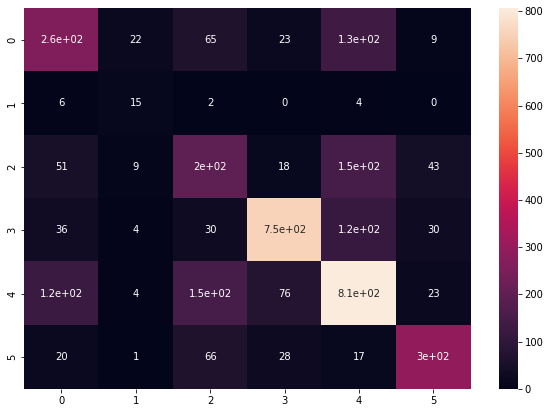

In [19]:
y_pred, y_true = print_report(model_1, dataloaders, class_names)
conf_matr = confusion_matrix(y_pred, y_true)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)

              precision    recall  f1-score   support

       Angry       0.52      0.49      0.51       495
     Disgust       0.61      0.25      0.36        55
        Fear       0.37      0.36      0.36       512
       Happy       0.79      0.82      0.81       899
 Sad_Neutral       0.67      0.68      0.67      1228
    Surprise       0.68      0.73      0.70       400

    accuracy                           0.64      3589
   macro avg       0.61      0.56      0.57      3589
weighted avg       0.64      0.64      0.64      3589



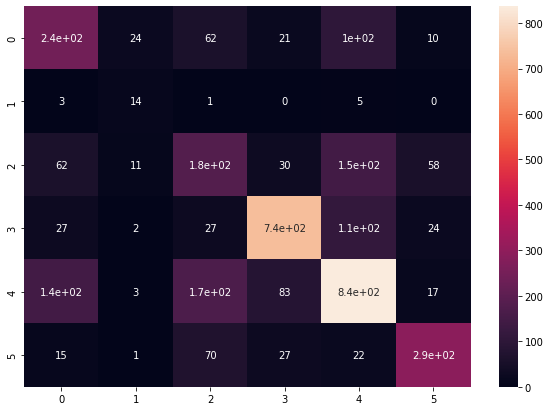

In [21]:
y_pred, y_true = print_report(model_2, dataloaders, class_names)
conf_matr = confusion_matrix(y_pred, y_true)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)

              precision    recall  f1-score   support

       Angry       0.52      0.46      0.49       495
     Disgust       0.48      0.44      0.46        55
        Fear       0.48      0.40      0.44       512
       Happy       0.78      0.76      0.77       899
 Sad_Neutral       0.61      0.71      0.66      1228
    Surprise       0.76      0.71      0.73       400

    accuracy                           0.64      3589
   macro avg       0.60      0.58      0.59      3589
weighted avg       0.64      0.64      0.64      3589



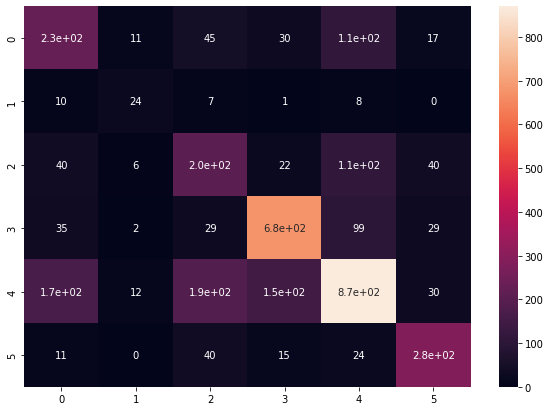

In [24]:
model_3 = model_3.to(device)
y_pred, y_true = print_report(model_3, dataloaders, class_names)
conf_matr = confusion_matrix(y_pred, y_true)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)

In [25]:
X_train, X_test = train_test_split(sad_neutral, test_size=0.1, random_state=1,stratify=sad_neutral['emotion'])

X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=1, stratify=X_train['emotion'])

X_test, y_test = split(X_test)
X_val, y_val = split(X_val)
X_train, y_train = split(X_train)

X_train = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_train).flatten()))
X_test = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_test).flatten()))
X_val = pd.DataFrame(map(lambda x: np.fromstring(x,dtype=int,sep=' '), np.array(X_val).flatten()))

print(sorted(Counter(y_train).items()))
ros = RandomOverSampler(random_state=0,sampling_strategy={0: 9000, 1: 9000})
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))


[(0, 4375), (1, 4462)]


/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (9000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 4462)
  f"After over-sampling, the number of samples ({n_samples})"
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:300: UserWarning: After over-sampling, the number of samples (9000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 4462)
  f"After over-sampling, the number of samples ({n_samples})"


[(0, 9000), (1, 9000)]


In [26]:
image_datasets = {'train': FeatureDataset(X_train,y_train), 
                  'val': FeatureDataset(X_val,y_val),
                  'test': FeatureDataset(X_test, y_test)}
dataset_sizes_last = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
dataloaders_last = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2)
               for x in ['train', 'val','test']}
class_names_last = ['Sad', 'Neutral']

In [39]:
model_last = torchvision.models.resnet18(pretrained=False)
model_last.conv1 = nn.Conv2d(1,64, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False)
model_last.fc = nn.Linear(in_features=512, out_features=2)
summary(model_last.cuda(),(1,48,48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]             576
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.Adam(model_last.parameters(),lr=0.005,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=6)
model_last = model_last.to(device)
model_last = train_model(model_last, criterion, optimizer_conv,exp_lr_scheduler,dataloaders_last, dataset_sizes_last, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6924 Acc: 0.5684
val Loss: 0.6587 Acc: 0.6068

Epoch 2/25
----------
train Loss: 0.6368 Acc: 0.6438
val Loss: 0.6418 Acc: 0.6507

Epoch 3/25
----------
train Loss: 0.5955 Acc: 0.6852
val Loss: 0.6521 Acc: 0.6692

Epoch 4/25
----------
train Loss: 0.5260 Acc: 0.7468
val Loss: 0.6220 Acc: 0.6742

Epoch 5/25
----------
train Loss: 0.4115 Acc: 0.8178
val Loss: 0.7250 Acc: 0.6498

Epoch 6/25
----------
train Loss: 0.2800 Acc: 0.8913
val Loss: 0.9394 Acc: 0.6425

Epoch 7/25
----------
train Loss: 0.1105 Acc: 0.9606
val Loss: 1.0956 Acc: 0.6638

Epoch 8/25
----------
train Loss: 0.0605 Acc: 0.9812
val Loss: 1.2203 Acc: 0.6602

Epoch 9/25
----------
train Loss: 0.0361 Acc: 0.9897
val Loss: 1.4788 Acc: 0.6593

Epoch 10/25
----------
train Loss: 0.0214 Acc: 0.9936
val Loss: 1.7123 Acc: 0.6643

Epoch 11/25
----------
train Loss: 0.0137 Acc: 0.9961
val Loss: 1.8540 Acc: 0.6611

Epoch 12/25
----------
train Loss: 0.0120 Acc: 0.9963
val Loss: 1.9321 Acc: 0.6638

E

              precision    recall  f1-score   support

         Sad       0.66      0.63      0.64       608
     Neutral       0.65      0.68      0.66       620

    accuracy                           0.65      1228
   macro avg       0.65      0.65      0.65      1228
weighted avg       0.65      0.65      0.65      1228



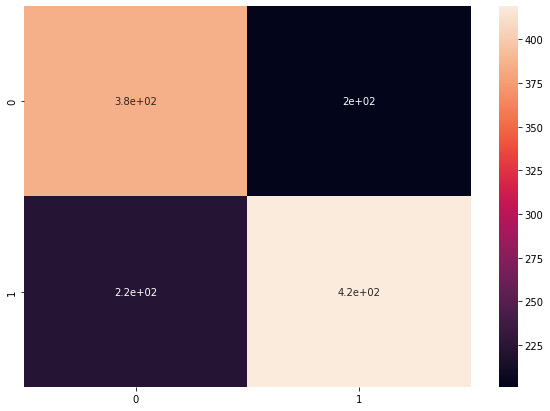

In [41]:
y_pred, y_true = print_report(model_last, dataloaders_last,class_names_last)
conf_matr = confusion_matrix(y_pred, y_true)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)

In [42]:
y_pred_final = torch.tensor([], dtype=int).to(device)
y_true_final = torch.tensor([], dtype=int).to(device)
with torch.no_grad():
    model_1.eval()
    model_last.eval()
    for inputs, labels in dataloaders['test_final']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_1(inputs)
        _, outputs = torch.max(outputs, dim = 1)
        for i in range(outputs.shape[0]):
          if outputs[i] == 4:
            input = inputs[i][None, :]
            output = model_last(input)
            _, output = torch.max(output, dim = 1)
            if output.item() == 1:
              outputs[i] = 6
            else:
              outputs[i] = 4
        y_pred_final = torch.cat((y_pred_final,outputs),0)
        y_true_final = torch.cat((y_true_final,labels),0) 

In [43]:
y_true_final = y_true_final.cpu()
y_pred_final = y_pred_final.cpu()
class_names_final = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(y_true_final,y_pred_final,target_names=class_names_final))

              precision    recall  f1-score   support

       Angry       0.51      0.52      0.51       495
     Disgust       0.56      0.27      0.37        55
        Fear       0.42      0.39      0.40       512
       Happy       0.77      0.84      0.81       899
         Sad       0.62      0.59      0.60       608
    Surprise       0.69      0.74      0.71       400
     Neutral       0.63      0.62      0.63       620

    accuracy                           0.63      3589
   macro avg       0.60      0.57      0.58      3589
weighted avg       0.63      0.63      0.63      3589



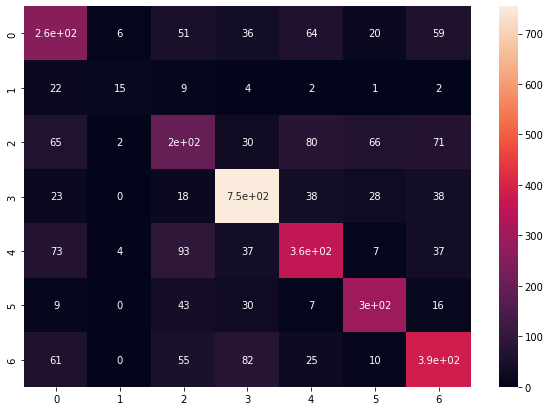

In [44]:
conf_matr = confusion_matrix(y_true_final,y_pred_final)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)

In [45]:
y_pred_final = torch.tensor([], dtype=int).to(device)
y_true_final = torch.tensor([], dtype=int).to(device)
with torch.no_grad():
    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_last.eval()
    for inputs, labels in dataloaders['test_final']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs_1 = model_1(inputs)
        outputs_2 = model_2(inputs)
        outputs_3 = model_3(inputs)
        outputs = outputs_1 * 0.6 + outputs_2 * 0.3 + outputs_3 * 0.1
        _, outputs = torch.max(outputs, dim = 1)
        for i in range(outputs.shape[0]):
          if outputs[i] == 4:
            input = inputs[i][None, :]
            output = model_last(input)
            _, output = torch.max(output, dim = 1)
            if output.item() == 1:
              outputs[i] = 6
            else:
              outputs[i] = 4
        y_pred_final = torch.cat((y_pred_final,outputs),0)
        y_true_final = torch.cat((y_true_final,labels),0) 

In [46]:
y_true_final = y_true_final.cpu()
y_pred_final = y_pred_final.cpu()
class_names_final = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(y_true_final,y_pred_final,target_names=class_names_final))

              precision    recall  f1-score   support

       Angry       0.59      0.53      0.56       495
     Disgust       0.69      0.33      0.44        55
        Fear       0.53      0.40      0.46       512
       Happy       0.81      0.83      0.82       899
         Sad       0.60      0.66      0.63       608
    Surprise       0.73      0.76      0.74       400
     Neutral       0.63      0.74      0.68       620

    accuracy                           0.67      3589
   macro avg       0.65      0.61      0.62      3589
weighted avg       0.66      0.67      0.66      3589



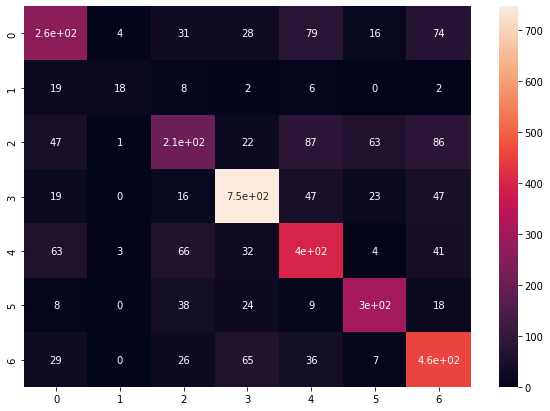

In [47]:
conf_matr = confusion_matrix(y_true_final,y_pred_final)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matr, annot=True)